## RAG (Retrieval-Augmented Generation) 구조 학습

이 노트북에서는 Retrieval-Augmented Generation(RAG)의 전체 구조를 구성하고, 각 구성 요소의 역할과 흐름을 실습을 통해 이해한다.

RAG는 단순한 언어 생성이 아닌, **외부 문서를 참조하여 신뢰 가능한 응답을 생성**하는 구조이다.  
이를 위해 다음과 같은 구성 요소가 결합된다:

### 핵심 구성 흐름

1. **문서 로딩 및 분할**  
   - 문서를 로딩하고 일정 단위로 나눔 (예: 문장, 단락 등)  
   - 도구: `TextLoader`, `TextSplitter`

2. **문서 임베딩 및 벡터 저장소 구성**  
   - 각 문서를 임베딩하여 벡터화하고 검색 가능한 벡터 인덱스로 저장  
   - 도구: `HuggingFaceEmbeddings`, `FAISS`

3. **질의 임베딩 및 유사 문서 검색**  
   - 사용자 질의를 벡터로 변환하고, 벡터 공간 상에서 유사 문서를 검색  
   - 도구: `Retriever`, cosine similarity 기반

4. **검색 문서를 기반으로 LLM 응답 생성**  
   - 선택된 문서를 context로 포함한 prompt를 구성하여 LLM이 조건부 응답 생성  
   - 도구: `RetrievalQA`, LLM 래퍼(Gemini API 기반)

### 학습 목표

- 전체 RAG 파이프라인의 구조와 동작 흐름 이해
- 각 구성 요소가 어떻게 연결되어 문서 기반 응답이 생성되는지 확인
- 질의 → 검색 → 응답 생성 과정의 수치적/구조적 분석 기반 확보

이 구조를 이해하는 것은 이후 실험(검색 품질, 분할 전략, agent 확장 등)의 기반이 된다.


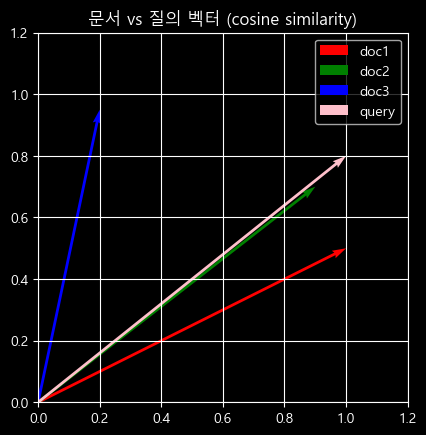

문서별 쿼리 유사도: [0.97780241 0.99990619 0.77216236]


c:\Users\Valentino\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\pydantic\_internal\_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(
C:\Users\Valentino\AppData\Local\Temp\ipykernel_28936\2219088098.py:100: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain.run("이 문서에서 RAG란?")


이 문서에서 RAG는 LLM 성능을 보완하는 기술이며, 할루시네이션을 커버하고 도메인 지식을 주입하는 등의 면에서 유용하다고 설명하고 있습니다.


In [2]:
# 1. 기본 설정 및 시각화
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib

matplotlib.rcParams["font.family"] = "Malgun Gothic"
matplotlib.rcParams["axes.unicode_minus"] = False

doc_vectors = np.array([[1.0, 0.5], [0.9, 0.7], [0.2, 0.95]])
query_vector = np.array([[1.0, 0.8]])
sims = cosine_similarity(query_vector, doc_vectors)[0]

fig, ax = plt.subplots()
colors = ["r", "g", "b"]
for i, vec in enumerate(doc_vectors):
    ax.quiver(
        0,
        0,
        vec[0],
        vec[1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color=colors[i],
        label=f"doc{i+1}",
    )
ax.quiver(
    0,
    0,
    query_vector[0][0],
    query_vector[0][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="pink",
    label="query",
)
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_aspect("equal")
ax.grid()
ax.legend()
plt.title("문서 vs 질의 벡터 (cosine similarity)")
plt.show()

print("문서별 쿼리 유사도:", sims)

# 2. LangChain 구성 요소 불러오기
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA

# 3. Gemini API 연결
import os
from dotenv import load_dotenv
import google.generativeai as genai

# .env에서 키 로드 및 설정
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)

# 모델 인스턴스 생성
model = genai.GenerativeModel("models/gemini-2.5-flash-preview-04-17")

# LangChain용 Custom LLM 래퍼 정의
from langchain.llms.base import LLM
from typing import Optional


class GeminiLLM(LLM):
    model: any

    def _call(self, prompt: str, stop: Optional[list[str]] = None) -> str:
        response = self.model.generate_content(prompt)
        return response.text

    @property
    def _llm_type(self) -> str:
        return "custom-gemini"


llm = GeminiLLM(model=model)

# 4. 문서 임베딩 및 QA 체인 구성
loader = TextLoader("example_docs/sample1.txt", encoding="utf-8")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(split_docs, embeddings)

qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=vectorstore.as_retriever())

# 5. 질의 실행
response = qa_chain.run("이 문서에서 RAG란?")
print(response)

In [ ]:
import google.generativeai as genai

genai.configure(api_key=api_key)

models = genai.list_models()
for model in models:
    print(model.name, model.supported_generation_methods)

### 1단계: 문서 벡터와 질의 벡터의 유사도 (Cosine Similarity)

문서 검색에서 질의와 문서 간의 관련성은 벡터 간의 코사인 유사도로 계산됨.  
두 벡터 $\vec{a}, \vec{b}$ 사이의 유사도는 다음과 같음:

$$
\cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \cdot \|\vec{b}\|}
$$

- 1에 가까울수록 두 벡터의 방향이 유사
- 벡터 방향의 유사성을 통해 관련 문서를 추정


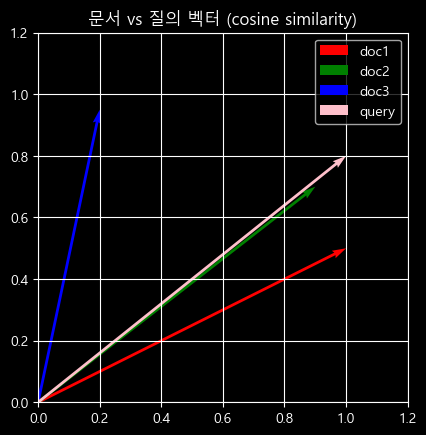

문서별 유사도: [0.97780241 0.99990619 0.77216236]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

doc_vectors = np.array([[1.0, 0.5], [0.9, 0.7], [0.2, 0.95]])
query_vector = np.array([[1.0, 0.8]])
sims = cosine_similarity(query_vector, doc_vectors)[0]

fig, ax = plt.subplots()
colors = ["r", "g", "b"]
for i, vec in enumerate(doc_vectors):
    ax.quiver(
        0,
        0,
        vec[0],
        vec[1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color=colors[i],
        label=f"doc{i+1}",
    )
ax.quiver(
    0,
    0,
    query_vector[0][0],
    query_vector[0][1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="pink",
    label="query",
)
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_aspect("equal")
ax.grid()
ax.legend()
plt.title("문서 vs 질의 벡터 (cosine similarity)")
plt.show()

print("문서별 유사도:", sims)

### 2단계: LangChain 기반 문서 전처리 및 벡터 저장

- `TextLoader`: 문서 로딩
- `RecursiveCharacterTextSplitter`: 문서 분할
- `HuggingFaceEmbeddings`: 벡터화
- `FAISS`: 벡터 검색 인덱스 구성

문서를 일정 단위로 나누고 각 조각을 고차원 벡터로 임베딩 후 검색용 저장소에 저장함.


In [ ]:
from langchain.document_loaders import TextLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document

# 문서 로드
loader = TextLoader("example_docs/sample1.txt", encoding="utf-8")
docs = loader.load()
print(f"원본 문서 수: {len(docs)}")

# 문장 단위로 직접 분리 (줄 단위로 나누고 공백 제거)
raw_text = docs[0].page_content
sentences = [s.strip() for s in raw_text.split("\n") if s.strip()]

# LangChain Document 형식으로 변환
split_docs = [Document(page_content=sent) for sent in sentences]
print(f"분할된 문장 수: {len(split_docs)}")
for i, doc in enumerate(split_docs):
    print(f"[{i}] {doc.page_content}")

# 임베딩 및 FAISS 저장소 구성
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(split_docs, embeddings)
print("벡터 저장소 내 벡터 수:", vectorstore.index.ntotal)

원본 문서 수: 1
분할된 문장 수: 3
[0] 1. rag는 llm 성능 보완 = 할루시네이션커버, 도메인 지식 인젝션 등 면에서 짱짱맨 기술인거임.
[1] 2. 지금 문장은 의도된 쿼리와 아무 연관이 없음
[2] 3. 이것도 아무 연관이 없는데 대답을 어떻게 하는지 볼거임. 배고픔
벡터 저장소 내 벡터 수: 3


### 구조적 해석: 왜 이렇게 처리하는가?

- **문장 단위 분리**: 문서 전체를 하나의 벡터로 임베딩하면, 질문에 대응할 수 없음  
  → 세부적인 문장 단위로 분리해야 "부분 대응"이 가능

- **임베딩**: 각 문장은 고차원 의미 벡터로 변환됨  
  → "RAG는 뭐야?"라는 질문 벡터와 가장 유사한 문장이 선택됨

- **FAISS 저장**: 모든 벡터를 인덱싱하여, 유사도 기반 검색이 빠르게 이뤄지도록 함  
  → 수천~수만 개 문서도 빠르게 검색 가능

- **주의사항**: 문장이 너무 길거나 짧으면 임베딩 특성이 왜곡될 수 있음  
  → 문장 길이 조절, 의미 단위 기준으로 분할 전략도 함께 고려


### 3단계: 질의(Query)를 임베딩 벡터로 변환

사용자의 질문은 단순한 문자열 텍스트이므로, 문서 검색을 위해선 벡터로 변환해야 함.  
이때 사용하는 것이 임베딩 모델이며, 동일한 모델로 문장과 질의를 임베딩해야 검색이 가능하다.

현재 사용하는 임베딩 모델:
- `sentence-transformers/all-MiniLM-L6-v2`
- 384차원 의미 공간을 기반으로 동작
- 쿼리를 입력하면 384차원의 벡터로 변환

이 벡터는 고차원 의미 공간에서 "문장 의미"를 표현한 점 하나로 볼 수 있음.


### 질의 임베딩 수학적 구조

입력 쿼리: 자연어 문장 → 토크나이즈 → 벡터 시퀀스 → 평균 풀링 → 고정차원 벡터

결과:  
$$
\vec{q} \in \mathbb{R}^{384}
$$

이 벡터는 문장 전체의 의미를 평균화하여 고차원 공간 상 하나의 점으로 표현한 것이다.


In [ ]:
# 질의 문장
query = "RAG란 무엇인가?"

# 질의를 임베딩 벡터로 변환
query_vector = embeddings.embed_query(query)

# 결과 확인
print("질의 임베딩 벡터 차원:", len(query_vector))
print("질의 임베딩 벡터 (앞 10차원):", query_vector[:10])

질의 임베딩 벡터 차원: 384
질의 임베딩 벡터 (앞 10차원): [-0.10312720388174057, 0.07886252552270889, 0.036757685244083405, -0.016478078439831734, -0.09243414551019669, -0.003082184586673975, 0.12861108779907227, 0.027548741549253464, -0.039407406002283096, -0.009369582869112492]


출력 예시:
- 차원: 384
- 앞 10차원: [-0.1031, 0.0788, 0.0367, -0.0164, -0.0924, -0.0030, 0.1286, 0.0275, -0.0394, -0.0093]

해석:
- 이 벡터는 "RAG란 무엇인가?"라는 문장이 의미적으로 어떤 위치에 있는지를 표현한 고차원 점
- 개별 수치는 특정 차원의 의미 축에 대한 위치를 나타냄 (예: 긍정도, 전문성, 추상성 등)
- 이 벡터와 문서 벡터 간의 cosine similarity로 의미적 관련성을 비교하게 됨


### 4단계: 질의 벡터와 문서 벡터 간 유사도 계산

이 단계에서는 임베딩된 질의 벡터와 각 문서 벡터 간의 유사도를 계산한다.

- 문서 벡터는 이전 단계에서 문장 단위로 FAISS에 저장됨
- 질의 벡터와 문서 벡터 간 유사도는 cosine similarity를 통해 계산
- 값이 클수록 두 벡터가 같은 방향, 즉 같은 의미를 가진다고 판단됨

이 유사도 값은 Retrieval 단계에서 어떤 문서를 선택할지를 결정하는 핵심 기준이 됨


### Cosine Similarity 수식

질의 벡터 $\vec{q}$와 문서 벡터 $\vec{d_i}$ 사이의 cosine 유사도는 다음과 같다:

$$
\text{sim}(\vec{q}, \vec{d_i}) = \frac{\vec{q} \cdot \vec{d_i}}{\|\vec{q}\| \cdot \|\vec{d_i}\|}
$$

- 내적 $\vec{q} \cdot \vec{d_i}$는 두 벡터의 방향 정렬 정도
- 분모는 각 벡터의 길이 (L2 정규화)
- 결과는 -1 ~ 1 사이의 값이며, 1에 가까울수록 유사한 방향

이 값을 기준으로 유사한 문서를 top-k 개수만큼 선택함


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 문서 벡터 집합 구성
doc_vectors = [embeddings.embed_query(doc.page_content) for doc in split_docs]

# cosine similarity 계산
import numpy as np

similarities = cosine_similarity([query_vector], doc_vectors)[0]

# 상위 k개 문서 인덱스 추출
top_k = 3
top_indices = np.argsort(similarities)[::-1][:top_k]

# 결과 출력
print("문서별 쿼리 유사도:", np.round(similarities, 4))
for i in top_indices:
    print(f"[{i}] 유사도={similarities[i]:.4f} → {split_docs[i].page_content}")

문서별 쿼리 유사도: [0.5292 0.4025 0.4812]
[0] 유사도=0.5292 → 1. rag는 llm 성능 보완 = 할루시네이션커버, 도메인 지식 인젝션 등 면에서 짱짱맨 기술인거임.
[2] 유사도=0.4812 → 3. 이것도 아무 연관이 없는데 대답을 어떻게 하는지 볼거임. 배고픔
[1] 유사도=0.4025 → 2. 지금 문장은 의도된 쿼리와 아무 연관이 없음


해석:
- 벡터 임베딩의 특성상 문장 구조나 일반적인 표현이 유사하면 높은 유사도로 나올 수 있음
- cosine similarity는 의미적 방향만 측정하므로 세밀한 의미 분리에는 한계가 있음

### 5단계: 질의-문서 간 유사도 분포 시각화

이 단계에서는 이전에 계산한 cosine similarity 값들을 시각화함으로써:

- 어떤 문장이 쿼리와 가장 관련이 높은지
- top-k 문장이 전체 문서 중 어떤 위치에 분포되어 있는지
- 임베딩된 의미 공간에서 문서들이 얼마나 밀집되어 있는지

를 직관적으로 파악할 수 있다.

이는 검색 정확도 향상, 벡터 품질 진단, 문장 분할 전략 평가 등에 활용됨.


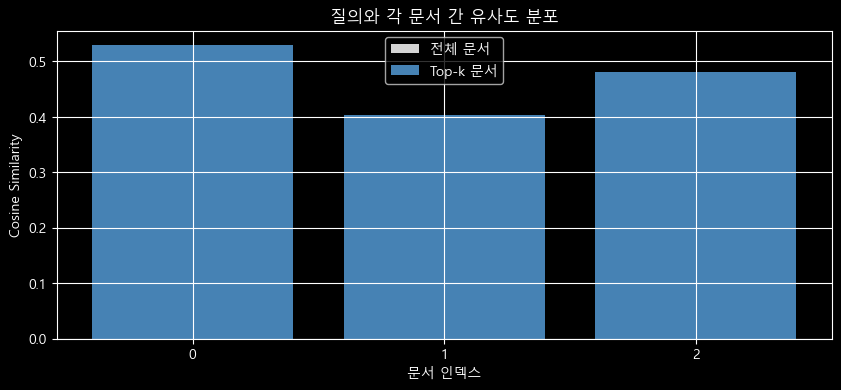

In [ ]:
import matplotlib.pyplot as plt

# 전체 유사도 막대그래프
plt.figure(figsize=(10, 4))
plt.bar(range(len(similarities)), similarities, color="lightgray", label="전체 문서")
plt.bar(
    top_indices,
    [similarities[i] for i in top_indices],
    color="steelblue",
    label="Top-k 문서",
)
plt.xlabel("문서 인덱스")
plt.ylabel("Cosine Similarity")
plt.title("질의와 각 문서 간 유사도 분포")
plt.xticks(range(len(similarities)))
plt.legend()
plt.grid(True)
plt.show()

#### 해석 예시

- 전체 유사도 값이 0.95 이상에 밀집되어 있으면 → 문서 임베딩 간 의미적 구분이 부족할 수 있음
- top-k 문서만 유사도가 뚜렷하게 높으면 → 검색 품질이 양호함
- 유사도가 전체적으로 낮으면 → 질의 벡터가 문서 임베딩 공간과 거리가 멀 수 있음
- top-1이 지나치게 0.99 이상이면 → 임베딩 모델이 특정 문장에 과도하게 반응한 것일 수도 있음 (편향)

이러한 분석을 통해 문서 분할 전략, 임베딩 모델 선택, 검색 기준(top-k 또는 threshold) 설정 등을 결정할 수 있다.


### 6단계: 선택된 문서가 LLM에 어떻게 전달되는가?

문서 검색 결과가 끝이 아니라, 선택된 문서 조각들이 **LLM에 prompt 형태로 전달**되어야 최종 응답이 생성된다.

LangChain의 `RetrievalQA` 체인은 다음과 같은 내부 흐름으로 작동한다:

1. 사용자 질의 → 임베딩 → Top-k 문서 검색
2. 검색된 문서들을 하나의 context로 합침
3. 다음과 같은 형태의 prompt를 생성:  

Context:
문서1 내용
문서2 내용
...

Question:
사용자 질문  


4. 위 prompt가 LLM(Gemini)에 전달됨
5. LLM은 context + question을 조건으로 언어 생성

→ 이는 **조건부 언어 생성 모델**로서의 LLM 구조에 기반한 동작임


In [ ]:
# RetrievalQA 실행
query = "RAG란 무엇인가?"
result = qa_chain(query)

# 응답 확인
print("🔹 생성된 응답:\n", result["result"])

# 사용된 문서 조각 확인
print("\n🔹 응답과정 중 리트리벌에 사용(고려)된 문서 조각 리스트:")
for i, doc in enumerate(result["source_documents"]):
    print(f"[{i}] {doc.page_content}")

🔹 생성된 응답:
 RAG는 LLM 성능을 보완하는 기술로, 할루시네이션을 커버하고 도메인 지식을 주입하는 등의 면에서 유용한 기술입니다.

🔹 응답과정 중 리트리벌에 사용(고려)된 문서 조각 리스트:
[0] 1. rag는 llm 성능 보완 = 할루시네이션커버, 도메인 지식 인젝션 등 면에서 짱짱맨 기술인거임.
[1] 3. 이것도 아무 연관이 없는데 대답을 어떻게 하는지 볼거임. 배고픔
[2] 2. 지금 문장은 의도된 쿼리와 아무 연관이 없음


#### LangChain PromptTemplate 내부 구조

실제로 LangChain은 다음과 같은 템플릿 구조를 사용:

---

{context}

Question: {query}  
Answer:

---

여기서 context는 Top-k 문서가 연결된 문자열이며, LLM은 이를 단일 문맥으로 처리함.  
LangChain은 내부적으로 `StuffDocumentsChain`을 통해 이 prompt를 구성함.

- context 양이 많으면 → 토큰 초과 위험
- context가 부정확하면 → 할루시네이션 가능성 증가
- query와 context의 의미 일치가 중요

LLM은 이 prompt 전체를 보고 조건부 확률 분포 $P(\text{답변} \mid \text{문서들}, \text{질문})$ 에 따라 응답을 생성함


### 7단계: Retrieval 문맥 포함 여부에 따른 응답 비교

RAG의 핵심은 "문서를 검색하여 LLM에 context로 제공하면, 그만큼 정답률이 높아지는가?"이다.

이 실험에서는 다음 두 조건을 비교함:

1. Retrieval 포함 (RAG) → 문서 context + 질문 → 응답
2. Retrieval 없음 (non-RAG) → 질문만 → 응답

이를 통해 다음을 검증할 수 있다:

- 문서 context가 없으면 LLM이 어떻게 추론하는가?
- 문서 context가 있을 때 얼마나 정답에 가까운가?
- 응답이 실제 문서를 반영하는가 (traceability)

실험 대상 질문 예: `"RAG란 무엇인가?"`


In [ ]:
# (1) RAG 방식: 문서 포함 (invoke 사용)
query = "RAG란 무엇인가?"
rag_result = qa_chain.invoke(query)

# 응답 출력 
print("✅ RAG 응답:\n", rag_result["result"])

# 사용된 문서 조각 출력
print("\n🔹 사용된 문서 조각:")
for i, doc in enumerate(rag_result["source_documents"]):
    print(f"[{i}] {doc.page_content}")

# (2) Non-RAG 방식: context 없이 직접 질의
non_rag_result = llm(query)
print("\n❌ Non-RAG 응답:\n", non_rag_result)

✅ RAG 응답:
 Helpful Answer: RAG는 LLM 성능을 보완하는 기술로, 할루시네이션을 커버하고 도메인 지식을 주입하는 데 유용한 기술입니다.

🔹 사용된 문서 조각:
[0] 1. rag는 llm 성능 보완 = 할루시네이션커버, 도메인 지식 인젝션 등 면에서 짱짱맨 기술인거임.
[1] 3. 이것도 아무 연관이 없는데 대답을 어떻게 하는지 볼거임. 배고픔
[2] 2. 지금 문장은 의도된 쿼리와 아무 연관이 없음


C:\Users\Valentino\AppData\Local\Temp\ipykernel_28000\2681134297.py:14: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  non_rag_result = llm(query)



❌ Non-RAG 응답:
 RAG는 **Retrieval Augmented Generation**의 약자입니다. 우리말로는 **검색 증강 생성**이라고 번역할 수 있습니다.

간단히 말해, RAG는 **거대 언어 모델(LLM, Large Language Model)**의 답변 정확성과 신뢰성을 높이기 위해, **외부의 신뢰할 수 있는 지식 소스**에서 관련 정보를 **검색(Retrieval)**해 와서, 이 정보를 기반으로 답변을 **생성(Generation)**하도록 **보강(Augmented)**하는 기술입니다.

**왜 RAG가 필요할까요?**

거대 언어 모델(LLM)은 방대한 데이터를 학습했지만 다음과 같은 한계가 있습니다.

1.  **최신 정보 부족:** 학습 시점에 제한이 있어 최신 정보나 사건에 대해 알지 못할 수 있습니다.
2.  **환각(Hallucination):** 사실이 아닌 내용을 마치 사실인 것처럼 지어내서 답변할 수 있습니다.
3.  **특정 도메인 지식 부족:** 특정 분야(예: 의료, 법률, 사내 문서)의 전문적인 정보에 대해서는 정확한 답변을 하기 어렵습니다.
4.  **출처 불분명:** 답변의 근거가 무엇인지 알기 어렵습니다.

RAG는 이러한 LLM의 한계를 보완하기 위해 등장했습니다.

**RAG의 작동 방식:**

일반적으로 다음과 같은 단계를 거칩니다.

1.  **사용자 질문:** 사용자가 LLM에게 질문합니다.
2.  **정보 검색 (Retrieval):** RAG 시스템이 사용자의 질문과 관련된 내용을 **미리 구축된 외부 지식 베이스** (예: 문서 데이터베이스, 웹 페이지 인덱스 등)에서 검색합니다. 이 단계에서는 질문의 의도를 파악하고 가장 관련성이 높은 문서나 정보 조각(청크)을 찾아냅니다.
3.  **정보 보강 (Augmentation):** 검색된 관련 정보 조각들은 사용자의 원래 질문과 함께 LLM에게 전달됩니다. 마치 "이 정보를 참고해서 답변해 줘"라고 가이드하는 것과 같습니다.
4.  **답

#### 예시 응답 비교

✅ RAG 응답:  
→ "이 문서에서 RAG는 LLM 성능 보완 기술로, 할루시네이션 방지 및 도메인 지식 주입 측면에서 효과적이라고 설명합니다."

❌ Non-RAG 응답:  
→ "RAG는 Retrieval-Augmented Generation의 약자로, 검색 기반 생성 기법을 말합니다. 일반적으로..."

#### 해석

- ✅ RAG 응답은 **문서에 실제로 포함된 표현**을 기반으로 응답을 생성함
- ❌ Non-RAG 응답은 **문서에 없는 내용**을 일반 지식으로 생성함  
  → **내용이 사실일 수는 있지만, 해당 문서(예를 들어, 직접 업로드 할 수 없고, 보안이슈를 끼고 있는 프로젝트, 비즈니스, 노하우 환경)와는 무관한 정보**

→ 이는 **문서 기반 응답의 traceability(근거 추적 가능성)**과  
   **응답 정당화(why this answer?)** 측면에서 RAG 구조가 훨씬 더 신뢰 가능하다는 것을 보여줌


### 핵심 개념 요약

- Retrieval-Augmented Generation(RAG)은 외부 문서를 검색하여 LLM의 응답 생성을 보완하는 구조
- 구성 절차:
  1. 문서를 임베딩 벡터로 변환
  2. 질의를 동일한 임베딩 공간의 벡터로 변환
  3. 문서들과 유사도를 계산하여 top-k 문서 검색
  4. 선택된 문서를 context로 삽입한 prompt 생성
  5. context + 질문 → LLM 응답 생성

### 주요 연산 및 구성 요소

- 임베딩 모델: sentence-transformers/all-MiniLM-L6-v2
- 유사도 계산: cosine similarity
- 벡터 검색 인덱스: FAISS
- 응답 생성 LLM: Gemini API + LangChain LLM 래퍼

### 실험 요약

- 문장을 단위로 나눈 문서에 대해 질의를 수행하고 관련 문서를 검색함
- 문서 기반 응답과 문서 없이 생성된 일반 응답을 비교하여, 근거 기반 응답(traceable response)의 효과를 확인함